### Data Set Information:

The goal of the research is to help the auditors by building a classification model that can predict the fraudulent firm on the basis the present and historical risk factors. The information about the sectors and the counts of firms are listed respectively as Irrigation (114), Public Health (77), Buildings and Roads (82), Forest (70), Corporate (47), Animal Husbandry (95), Communication (1), Electrical (4), Land (5), Science and Technology (3), Tourism (1), Fisheries (41), Industries (37), Agriculture (200).

Consider ``Risk`` as target columns for classfication task.
### Attribute Information:
Many risk factors are examined from various areas like past records of audit office, audit-paras, environmental conditions reports, firm reputation summary, on-going issues report, profit-value records, loss-value records, follow-up reports etc. After in-depth interview with the auditors, important risk factors are evaluated and their probability of existence is calculated from the present and past records.


### Relevant Papers:
Hooda, Nishtha, Seema Bawa, and Prashant Singh Rana. 'Fraudulent Firm Classification: A Case Study of an External Audit.' Applied Artificial Intelligence 32.1 (2018): 48-64.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns

In [3]:
# Import files
ar = pd.read_csv('../wk4/audit_risk.csv')
tr = pd.read_csv('../wk4/trial.csv')
print(ar.shape)
print(tr.shape)

(776, 27)
(776, 18)


In [4]:
# comapre column names 
ar_cols = ar.columns
tr_cols = tr.columns

common_cols = ar_cols.intersection(tr_cols)
ar_not_tr = ar_cols.difference(tr_cols)
tr_not_ar = tr_cols.difference(ar_cols)

In [5]:
# Modify common column names and compare their values
# Risk has different values in ar and tr, rest of the common columns have the same values
# Combine two datasets into one (Keep only one copy of the common columns)

tr.rename(columns={'Risk':'tRisk'}, inplace=True) # replace Risk in tr with tRisk 

ar_cols = ar.columns
tr_cols = tr.columns
tr_not_ar = tr_cols.difference(ar_cols)

df = pd.concat([ar,tr[tr_not_ar]], axis=1)
df.shape

(776, 36)

In [6]:
df.isnull().values.sum()

1

In [7]:
# Money_value and aMoney_value have Nan
df[df.isnull().any(1)]

,Sector_score,LOCATION_ID,PARA_A,Score_A,Risk_A,PARA_B,Score_B,Risk_B,TOTAL,numbers,...,Risk,District,History_score,LOSS_SCORE,Loss,MONEY_Marks,Marks,SCORE_A,SCORE_B,tRisk
642,55.57,4,0.23,0.2,0.046,0.0,0.2,0.0,0.23,5.0,...,0,2,2,2,0,2,2,2,2,0


In [8]:
# Fill NAN with mean

print('Money_Value with NaN:',df.loc[:,'Money_Value'].sum())

df['Money_Value'] = df['Money_Value'].fillna(df['Money_Value'].mean())

print('Repalce NaN with mean:',df.loc[:,'Money_Value'].sum())


Money_Value with NaN: 10956.663999999999
Repalce NaN with mean: 10970.80163096774


In [9]:
# Select columns based on their types
flo_vars = list(df.select_dtypes(include=[np.float64]))
int_vars = list(df.select_dtypes(include=[np.int64]))

In [10]:
# Select columns with less than 2 unique values :Detection_Risk'
less2 =[]
for flo in flo_vars:
    a = len(np.unique(df[flo]))
    if a < 2:
        print(flo,', unique values:', a)
        less2.append(flo)
print(less2)        

Detection_Risk , unique values: 1
['Detection_Risk']


In [11]:
# Select columns with less than 2 unique values : Not found
les2 =[]
for it in int_vars:
    a = len(np.unique(df[it]))
    if a < 2:
        print(it,', unique values:', a)
        less2.append(it)
print(les2)

[]


In [12]:
# drop "Detection_Risk"
df = df.drop(['Detection_Risk'], axis=1)

In [13]:
# 10x Score_A = SCORE_A , 10x Score_B = SCORE_B

df = df.drop(['Score_A','Score_B'], axis=1)

In [14]:
# Reorganize column types
dfnames = list(df)

new_flo = list(df.select_dtypes(include=[np.float64]))
new_int = list(df.select_dtypes(include=[np.int64]))

print(len(new_flo),len(new_int))


20 12


In [15]:
# District  = District_Loss 

df = df.drop(['District'], axis=1)

In [16]:
#  2x Money_Value = Risk_D, PARA_A = 50x Risk_A,PARA_B = 50x Risk_B

df = df.drop(['Risk_D','Risk_B','Risk_A'], axis=1)

In [17]:
# Rename Location_ID (character to number)
a =[]
for i in df.LOCATION_ID:
    if i == 'SAFIDON':
        new_val = 101
    elif i == 'NUH':
        new_val = 102
    elif i == 'LOHARU':
        new_val = 1003
    else:
        new_val = int(i)
    a.append(new_val)
    #df.LOCATION_ID.replace(i,new_val)
df.LOCATION_ID = a

C:\Users\clfee\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0,0.5,'Counts')

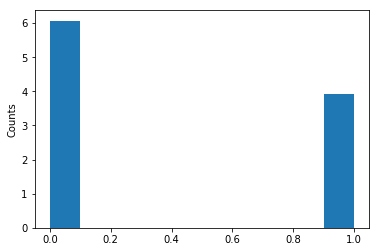

In [18]:
import matplotlib.pyplot as plt

#%matplotlib inline

#plt.plot(df['Risk'])
plt.hist(df['Risk'], normed=True, bins=10)
plt.ylabel('Counts')



In [19]:
# Define independent and dependent variables
# Minmax Scaler used in Classification

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# split data

X = df.drop(['Risk'], axis = 1)
y = df['Risk']

scaler = MinMaxScaler()
X_train_org, X_test_org, y_train, y_test = train_test_split(X, y, random_state =15678 , test_size = 0.15)


X_train = scaler.fit_transform(X_train_org)
X_test  = scaler.transform(X_test_org)

### Hard | Soft Voting

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Decision Tree parameters are adapted from previou result  

grid_no = {'n_neighbors'  : [ 5, 10, 20, 50]}
grid_values = {'max_depth'  : [ 5, 10, 20, 50],
              'n_estimators': [ 10, 50, 100, 200, 500]}
grid_para = {'C'  : [ 5, 10, 20, 50],
             'gamma'  : [ 10, 30, 50, 80]}

knn_clf = KNeighborsClassifier()
grid_knn = GridSearchCV(knn_clf, cv = 5, param_grid = grid_no)

rnd_clf = RandomForestClassifier()
grid_rnd = GridSearchCV(rnd_clf, cv = 5, param_grid = grid_values)

#svm_clf = SVC(probability = True)
svm_clf = SVC(kernel = 'rbf', probability = True)
grid_svm = GridSearchCV(svm_clf, cv = 5, param_grid = grid_para)

grid_knn.fit(X_train, y_train)
grid_rnd.fit(X_train, y_train)
grid_svm.fit(X_train, y_train)

print('Grid best parameter KNN (max. accuracy): ', grid_knn.best_params_)
print('Grid best score KNN (accuracy): ', grid_knn.best_score_)

print('Grid best parameter Random Forest (max. accuracy): ', grid_rnd.best_params_)
print('Grid best score Random Forest (accuracy): ', grid_rnd.best_score_)

print('Grid best parameter SVM (max. accuracy): ', grid_svm.best_params_)
print('Grid best score SVM (accuracy): ', grid_svm.best_score_)

Grid best parameter KNN (max. accuracy):  {'n_neighbors': 5}
Grid best score KNN (accuracy):  0.9620637329286799
Grid best parameter Random Forest (max. accuracy):  {'max_depth': 5, 'n_estimators': 100}
Grid best score Random Forest (accuracy):  1.0
Grid best parameter SVM (max. accuracy):  {'C': 20, 'gamma': 50}
Grid best score SVM (accuracy):  0.9681335356600911


In [21]:
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import VotingClassifier

dummy_majority = DummyClassifier(strategy='most_frequent')
dummy_majority.fit(X_train, y_train)

pred_most_frequent = dummy_majority.predict(X_test)

# Apply best parameters

gknn = KNeighborsClassifier(**grid_knn.best_params_)
gknn.fit(X_train, y_train)
grnd = RandomForestClassifier(**grid_rnd.best_params_, random_state=42)
grnd.fit(X_train, y_train)
gsvc = SVC(**grid_svm.best_params_, random_state=42, probability = True)
gsvc.fit(X_train, y_train)

voting_clf = VotingClassifier(estimators=[('rnd', grnd), ('svc', gsvc),('knn', gknn)], voting='hard')
voting_clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
for clf in (gknn,gsvc, grnd, voting_clf):
    clf.fit(X_train, y_train)
    hy_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, hy_pred))

print("Unique predicted labels: {}".format(np.unique(pred_most_frequent)))
print("Dummy Test score: {:.2f}".format(dummy_majority.score(X_test, y_test)))

from sklearn.metrics import classification_report

print(classification_report(y_test, pred_most_frequent, target_names=["0", "1"]))
print('Hard Voting:',classification_report(y_test, hy_pred, target_names=["0", "1"]))

KNeighborsClassifier 0.9658119658119658
SVC 0.9829059829059829
RandomForestClassifier 0.9914529914529915
VotingClassifier 0.9829059829059829
Unique predicted labels: [0]
Dummy Test score: 0.59
             precision    recall  f1-score   support

          0       0.59      1.00      0.74        69
          1       0.00      0.00      0.00        48

avg / total       0.35      0.59      0.44       117

Hard Voting:              precision    recall  f1-score   support

          0       0.97      1.00      0.99        69
          1       1.00      0.96      0.98        48

avg / total       0.98      0.98      0.98       117



C:\Users\clfee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\clfee\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [22]:
# Soft voting
voting_clf = VotingClassifier(estimators=[('rnd', grnd), ('svc', gsvc),('knn', gknn)], voting='soft')
voting_clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
for clf in (gknn,grnd, gsvc, voting_clf):
    clf.fit(X_train, y_train)
    sy_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, sy_pred))
    
print('Soft Voting:',classification_report(y_test, sy_pred, target_names=["0", "1"]))

KNeighborsClassifier 0.9658119658119658
RandomForestClassifier 0.9914529914529915
SVC 0.9829059829059829
VotingClassifier 0.9829059829059829
Soft Voting:              precision    recall  f1-score   support

          0       0.97      1.00      0.99        69
          1       1.00      0.96      0.98        48

avg / total       0.98      0.98      0.98       117



C:\Users\clfee\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [23]:
# F1 score

from sklearn.metrics import f1_score

print("f1 score most frequent: {:.2f}".format(f1_score(y_test, pred_most_frequent)))
print("f1 score hard: {:.2f}".format(f1_score(y_test, hy_pred)))
print("f1 score soft: {:.2f}".format(f1_score(y_test, sy_pred)))


f1 score most frequent: 0.00
f1 score hard: 0.98
f1 score soft: 0.98


C:\Users\clfee\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [24]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, sy_pred)

array([[69,  0],
       [ 2, 46]], dtype=int64)

<IPython.core.display.Javascript object>


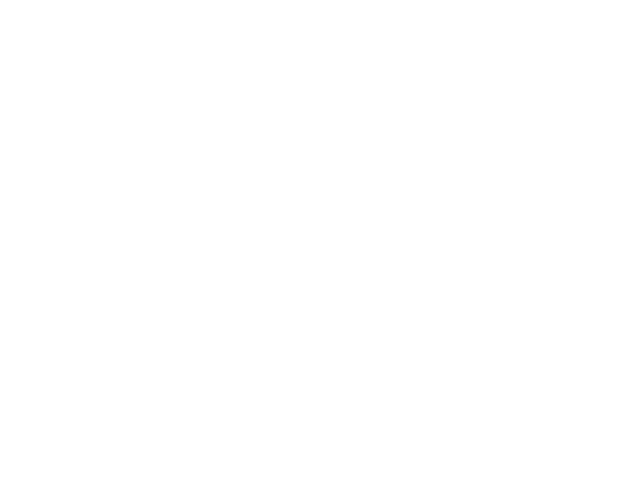

In [25]:
# Plot curve 
from sklearn.metrics import precision_recall_curve
%matplotlib notebook

precision, recall, thresholds = precision_recall_curve(y_test, gsvc.decision_function(X_test))

close_zero = np.argmin(np.abs(thresholds))

plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)

plt.plot(precision, recall, label="precision recall curve")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")

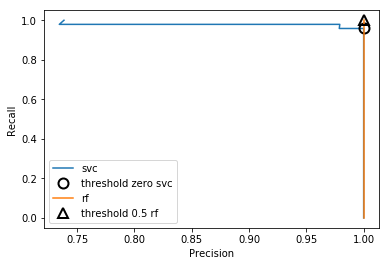

In [26]:
# RandomForestClassifier has predict_proba, but not decision_function
%matplotlib inline
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, grnd.predict_proba(X_test)[:, 1])

plt.plot(precision, recall, label="svc")

plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10,
         label="threshold zero svc", fillstyle="none", c='k', mew=2)

plt.plot(precision_rf, recall_rf, label="rf")

close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(precision_rf[close_default_rf], recall_rf[close_default_rf], '^', c='k',
         markersize=10, label="threshold 0.5 rf", fillstyle="none", mew=2)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")

In [27]:
# Using permutation importance to determine wich features are important, and see if we can lower the MSE

import eli5
from eli5.sklearn import PermutationImportance

var = list(X)

perm = PermutationImportance(gsvc, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = var)

Weight,Feature
0.3248 ± 0.0390,tRisk
0.2803 ± 0.0294,SCORE_A
0.2530 ± 0.0754,Score
0.2359 ± 0.0298,SCORE_B
0.1761 ± 0.0413,MONEY_Marks
0.1419 ± 0.0502,Score_MV
0.1060 ± 0.0278,RiSk_E
0.0889 ± 0.0352,District_Loss
0.0547 ± 0.0084,Score_B.1
0.0513 ± 0.0359,Marks


### Classfication Neural networks

In [28]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from keras.wrappers.scikit_learn import KerasClassifier

C:\Users\clfee\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [44]:
# create model
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
model.fit(X_train, y_train, epochs=100, batch_size=10,validation_split = 0.1,verbose = 0)

In [45]:
y_predict = model.predict(X_test)

a = []
for i in y_predict:
    if i >= 0.5:
        y_pred = 1
    else:
        y_pred = 0
    a.append(y_pred)
    #df.LOCATION_ID.replace(i,new_val)
ny_pred = a
#print(y_pred)
print('neural network:',classification_report(y_test, ny_pred, target_names=["0", "1"]))

neural network:              precision    recall  f1-score   support

          0       0.99      1.00      0.99        69
          1       1.00      0.98      0.99        48

avg / total       0.99      0.99      0.99       117



In [46]:
confusion_matrix(y_test, ny_pred)

array([[69,  0],
       [ 1, 47]], dtype=int64)

In [47]:
# Model evaluation
score = model.evaluate(X_test, y_test, verbose = 0)
print('test loss:', score[0])

test loss: 0.033155772023094006
